In [8]:
import sys
sys.path.append('../')

from typing import Union, Tuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy

from src.utils import get_data_and_feed
from scipy.integrate import odeint

import torch
import torch.nn as nn
from tqdm import tqdm 

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'
print(DEVICE)

cpu


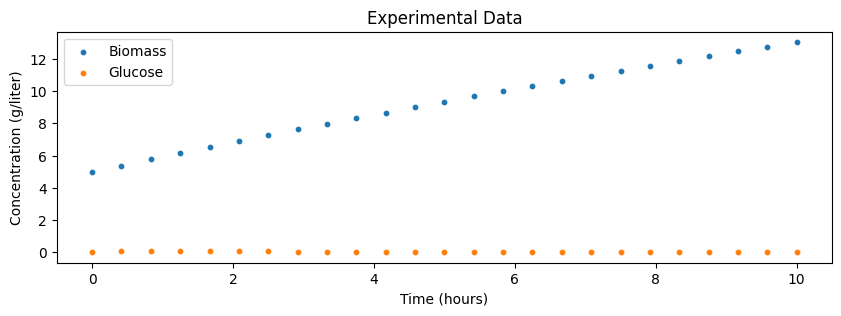

In [9]:
T_START = 0
T_END = 10
NUM_SAMPLES = 25

# parameter values
mumax = 0.86      # 1/hour
Ks = 0.3         # g/liter
Yxs = 0.2        # g/g
Sin = 1.43 * 200        # g/liter

# inlet flowrate
def Fs(t):
    # if t <= 2.2:
    #     return 0.017
    # # elif t <= 5.5:
    # #     return 0.031
    # elif t <= 8.6:
    #     return 0.03
    # else:
    #     return 0.02
    return 0.02

def simulate(mumax, Ks, Yxs, Sin, T_START, T_END, NUM_SAMPLES):
    
    mumax = mumax
    Ks = Ks
    Yxs = Yxs
    
    # reaction rates
    def mu(S):
        return mumax*S/(Ks + S)

    def Rg(X,S):
        return mu(S)*X

    # differential equations
    def xdot(x,t):
        X,S,V = x
        dX = -Fs(t)*X/V + Rg(X,S)
        dS = Fs(t)*(Sin-S)/V - Rg(X,S)/Yxs
        dV = Fs(t)
        return [dX,dS,dV]

    IC = [5, 0.01, 1.1]

    t = np.linspace(T_START,T_END,NUM_SAMPLES)
    sol = odeint(xdot,IC,t)

    return sol

X,S,V = simulate(mumax, Ks, Yxs, Sin, T_START, T_END, NUM_SAMPLES).transpose()

# Generate dataset 
t = np.linspace(T_START,T_END,NUM_SAMPLES)
full_df = pd.DataFrame({'RTime': t, 'Biomass': X, 'Glucose': S, 'V': V})

# Plot 
plt.figure(figsize=(10,3))  
plt.scatter(t,full_df['Biomass'],s=10,label='Biomass')
plt.scatter(t,full_df['Glucose'],s=10,label='Glucose')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (g/liter)')
plt.title('Experimental Data')
plt.legend()
plt.show()

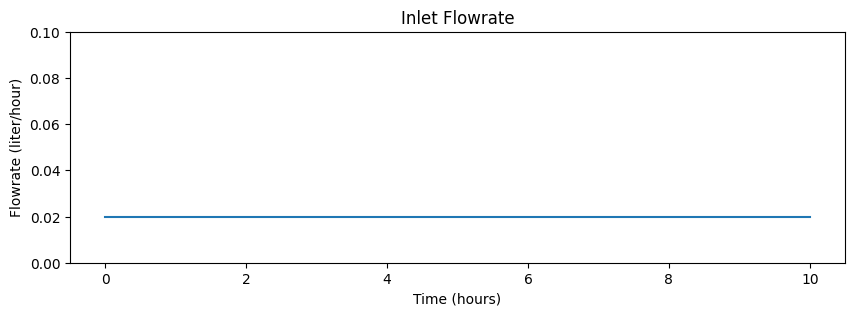

In [10]:
# Plot Fs(t) 
Fs_t = [Fs(i) for i in np.linspace(T_START,T_END,1000)]
plt.figure(figsize=(10,3))
plt.plot(np.linspace(T_START,T_END,1000),Fs_t)
plt.xlabel('Time (hours)')
plt.ylabel('Flowrate (liter/hour)')
plt.title('Inlet Flowrate')
plt.ylim(0,0.1)
plt.show()

In [11]:
def numpy_to_tensor(array):
    return (
        torch.tensor(array, requires_grad=True, dtype=torch.float32)
        .to(DEVICE)
        .reshape(-1, 1)
    )

class PINN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
    ):
        super().__init__()
        self.input = nn.Linear(input_dim, 16)
        self._ = nn.Linear(16, 32)
        self.hidden = nn.Linear(32, 256)
        self.hidden2 = nn.Linear(256, 256)
        self.hidden3 = nn.Linear(256, 32)
        self.__ = nn.Linear(32, 16)
        self.output = nn.Linear(16, output_dim)

        self.mu_max = nn.Parameter(torch.tensor(0.5, dtype=torch.float32))
        self.K_s = nn.Parameter(torch.tensor(0.5, dtype=torch.float32))
        self.Y_xs = nn.Parameter(torch.tensor(0.5, dtype=torch.float32))

    def forward(self, x):
        x = torch.relu(self.input(x))
        x = torch.relu(self._(x))
        x = torch.relu(self.hidden(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = torch.relu(self.__(x))
        x = self.output(x)
        return x

def grad(outputs, inputs):
    """Computes the partial derivative of 
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )

def loss_fn(
    net: torch.nn.Module,
    t_start: Union[np.float32, torch.Tensor],
    t_end: Union[np.float32, torch.Tensor],
) -> torch.Tensor:
    
    t = torch.linspace(t_start, t_end, steps=100,).view(-1, 1).requires_grad_(True).to(DEVICE)

    # F = torch.tensor([Fs(i) for i in t]).view(-1, 1).to(DEVICE)
    
    u_pred = net.forward(t)
    X_pred = u_pred[:, 0].view(-1, 1)
    S_pred = u_pred[:, 1].view(-1, 1)
    V_pred = u_pred[:, 2].view(-1, 1)

    dXdt_pred = grad(X_pred, t)[0]
    dSdt_pred = grad(S_pred, t)[0]
    dVdt_pred = grad(V_pred, t)[0]

    mu = net.mu_max * S_pred / (net.K_s + S_pred)

    error_dXdt = nn.MSELoss()(
        dXdt_pred, mu * X_pred - X_pred * 0.02 / V_pred
    )
    error_dSdt = nn.MSELoss()(
        dSdt_pred, - mu * X_pred / net.Y_xs + 0.02 / V_pred * (Sin - S_pred)
    )
    error_dVdt = nn.MSELoss()(
        dVdt_pred, torch.ones_like(dVdt_pred) * 0.02
    )

    error_ode = error_dXdt + error_dSdt + error_dVdt
    return error_ode


In [12]:
TRAIN_SIZE = 25 
t_train = np.linspace(T_START,T_END,TRAIN_SIZE)
df = full_df.iloc[:TRAIN_SIZE].copy()

In [13]:
t_train = numpy_to_tensor(t_train).to(DEVICE)
Biomass_train = numpy_to_tensor(df["Biomass"].values).to(DEVICE)
Glucose_train = numpy_to_tensor(df["Glucose"].values).to(DEVICE)
V_train = numpy_to_tensor(df["V"].values).to(DEVICE)
u_train = torch.cat((Biomass_train, Glucose_train, V_train), 1).to(DEVICE)

net = PINN(1,3).to(DEVICE)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)
# scheduler = torch.optim.lr_scheduler.LambdaLR(
#     optimizer, lr_lambda=lambda epoch: min(1.0, epoch / 10)
# )

def train(net, optimizer, t_train, u_train):
    # Initialize early stopping variables
    best_loss = float('inf')
    best_model_weights = None
    patience = 100

    num_epochs = 50000
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        u_pred = net.forward(t_train)
        
        # if epoch == 100:
        #     if torch.any(u_pred < 0):
        #         raise ValueError("Initial prediction is negative")
            
        # Data loss
        X_data_loss = nn.MSELoss()(u_pred[:,0], u_train[:,0])
        S_data_loss = nn.MSELoss()(u_pred[:,1], u_train[:,1])
        V_data_loss = nn.MSELoss()(u_pred[:,2], u_train[:,2])
        loss_data = (X_data_loss + S_data_loss + V_data_loss)  
        
        # IC loss
        X_ic_loss = nn.MSELoss()(u_pred[0,0], u_train[0,0])
        S_ic_loss = nn.MSELoss()(u_pred[0,1], u_train[0,1])
        V_ic_loss = nn.MSELoss()(u_pred[0,2], u_train[0,2])
        loss_ic = (X_ic_loss + S_ic_loss + V_ic_loss) 
        
        # # ODE loss
        loss_ode = loss_fn(net, T_START, T_END) 
        
        # # Total Loss
        loss = loss_data + loss_ic + loss_ode
        loss.backward()
        optimizer.step()
        # scheduler.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f} data loss: {loss_data.item():.4f}, IC loss: {loss_ic.item():.4f}, ODE loss: {loss_ode.item():.4f}")
            print(f"mu_max: {net.mu_max.item():.4f}, K_s: {net.K_s.item():.4f}, Y_xs: {net.Y_xs.item():.4f}")

        # Early stopping
        if loss < best_loss:
            best_loss = loss
            best_model_weights = copy.deepcopy(net.state_dict())
            patience = 100
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping at epoch {epoch}")   
                net.load_state_dict(best_model_weights)
                break  
            
    t_test = torch.linspace(T_START, T_END, 100).view(-1, 1).to(DEVICE)
    net_df = pd.DataFrame()
    net_df['RTime'] = t_test.cpu().detach().numpy().flatten()   
    net_df['Biomass'] = net(t_test).cpu().detach().numpy()[:,0]
    net_df['Glucose'] = net(t_test).cpu().detach().numpy()[:,1]
    net_df['V'] = net(t_test).cpu().detach().numpy()[:,2]
    
    return net, net_df, loss

In [14]:
repeat = True
while repeat:
    try:
        net, net_df, loss = train(net, optimizer, t_train, u_train)
        repeat = False
    except ValueError:
        pass
    

Epoch 0 | Loss: 3807.9932 data loss: 94.8757, IC loss: 27.6463, ODE loss: 3685.4712
mu_max: 0.5000, K_s: 0.5000, Y_xs: 0.5000
Epoch 100 | Loss: 1883.3188 data loss: 94.1704, IC loss: 27.5372, ODE loss: 1761.6113
mu_max: 0.5010, K_s: 0.4990, Y_xs: 0.4990
Epoch 200 | Loss: 1262.2410 data loss: 93.7831, IC loss: 27.4360, ODE loss: 1141.0219
mu_max: 0.5019, K_s: 0.4981, Y_xs: 0.4981
Epoch 300 | Loss: 920.8784 data loss: 93.5800, IC loss: 27.3541, ODE loss: 799.9443
mu_max: 0.5028, K_s: 0.4969, Y_xs: 0.4972
Epoch 400 | Loss: 706.2186 data loss: 93.4853, IC loss: 27.2721, ODE loss: 585.4612
mu_max: 0.5039, K_s: 0.4955, Y_xs: 0.4961
Epoch 500 | Loss: 540.8586 data loss: 93.5323, IC loss: 27.2279, ODE loss: 420.0984
mu_max: 0.5052, K_s: 0.4936, Y_xs: 0.4948
Epoch 600 | Loss: 444.7763 data loss: 93.5894, IC loss: 27.2170, ODE loss: 323.9698
mu_max: 0.5068, K_s: 0.4931, Y_xs: 0.4930
Epoch 700 | Loss: 385.6125 data loss: 93.5148, IC loss: 27.1893, ODE loss: 264.9084
mu_max: 0.5081, K_s: 0.4940, Y

In [15]:
print(f'Loss: {loss.item():.4f}')
print(f'mu_max: {net.mu_max.item():.4f}, K_s: {net.K_s.item():.4f}, Y_xs: {net.Y_xs.item():.4f}')

Loss: 0.2099
mu_max: 0.6414, K_s: 0.3848, Y_xs: 0.3216


In [16]:
t_test = np.linspace(T_START,T_END,100)
X_test,S_test,V_test = simulate(net.mu_max.item(), net.K_s.item(), net.Y_xs.item(), Sin, T_START, T_END, 100).transpose()

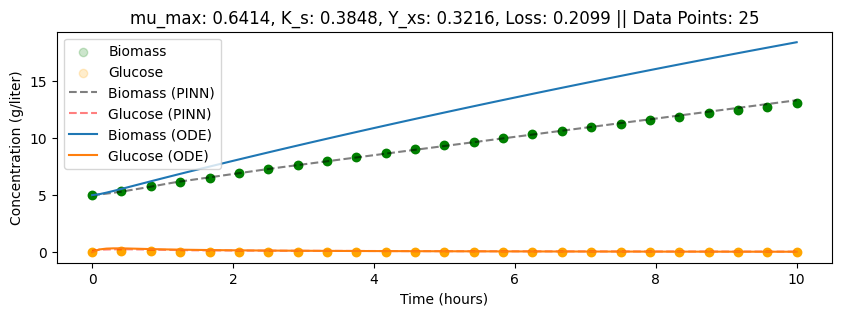

In [17]:
plt.figure(figsize=(10,3))
plt.scatter(full_df['RTime'],full_df['Biomass'],label='Biomass', color='green', alpha=0.2)
plt.scatter(full_df['RTime'],full_df['Glucose'],label='Glucose', color='orange', alpha=0.2)
plt.scatter(df['RTime'],df['Biomass'],label='_Biomass', color='green', alpha=1.0)
plt.scatter(df['RTime'],df['Glucose'],label='_Glucose', color='orange', alpha=1.0)

plt.plot(net_df['RTime'],net_df['Biomass'],label='Biomass (PINN)', linestyle='--', color='black', alpha=0.5)
plt.plot(net_df['RTime'],net_df['Glucose'],label='Glucose (PINN)', linestyle='--', color='red', alpha=0.5)

plt.plot(t_test,X_test,label='Biomass (ODE)')
plt.plot(t_test,S_test,label='Glucose (ODE)')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (g/liter)')
plt.legend()
plt.title(f'mu_max: {net.mu_max.item():.4f}, K_s: {net.K_s.item():.4f}, Y_xs: {net.Y_xs.item():.4f}, Loss: {loss.item():.4f} || Data Points: {TRAIN_SIZE}')
plt.savefig(f'../plots/fed_batch_{TRAIN_SIZE}.png')
plt.show()